In [1]:
import pandas as pd
import numpy as np

In [3]:
qc_raw = pd.read_csv("snap_qc_data_2017to2023.csv", encoding = "latin1")

In [5]:
qc_raw.head(5)

,Case ID,agency,Error Type,Error Nature,Error Element,Error Timing,Error Discovery,Dollar Amount in Error,State,Status of Error Findings,Case Type,Error Responsibility,Year
0,10,1,Arithmetic computation error,More income received from this source than bud...,Wages and salaries,At time of most recent action by agency,Employer (present or former),179.0,Connecticut,Overissuance,Certification,Technical Errors,2017
1,10,2,"Incomplete or incorrect information provided, ...",Deduction that should have been included was not,Shelter deduction,At time of most recent action by agency,From information provided by recipient,NaN,Connecticut,Overissuance,Certification,Client Errors,2017
2,11,1,Information not reported by client,NaN,Wages and salaries,NaN,Other,1.0,Connecticut,Overissuance,Certification,Client Errors,2017
3,25,1,Information withheld by client (case referred ...,More income received from this source than bud...,Wages and salaries,At time of most recent action by agency,Employer (present or former),109.0,Connecticut,Overissuance,Recertification,Client Errors,2017
4,32,1,Information not reported by client,NaN,Wages and salaries,NaN,Other,36.0,Connecticut,Overissuance,Recertification,Client Errors,2017


In [7]:
print(qc_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72072 entries, 0 to 72071
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Case ID                   72072 non-null  int64  
 1   agency                    72072 non-null  int64  
 2   Error Type                72057 non-null  object 
 3   Error Nature              59457 non-null  object 
 4   Error Element             72072 non-null  object 
 5   Error Timing              71369 non-null  object 
 6   Error Discovery           72072 non-null  object 
 7   Dollar Amount in Error    45267 non-null  float64
 8   State                     72072 non-null  object 
 9   Status of Error Findings  72072 non-null  object 
 10  Case Type                 72072 non-null  object 
 11  Error Responsibility      72057 non-null  object 
 12  Year                      72072 non-null  int64  
dtypes: float64(1), int64(3), object(9)
memory usage: 7.1+ MB
None

In [9]:
keep_cols = ["State", "Year", "Error Element", "Error Type", "Error Responsibility"]

qc = qc_raw[keep_cols]

qc = qc.dropna()

qc.head(5)

,State,Year,Error Element,Error Type,Error Responsibility
0,Connecticut,2017,Wages and salaries,Arithmetic computation error,Technical Errors
1,Connecticut,2017,Shelter deduction,"Incomplete or incorrect information provided, ...",Client Errors
2,Connecticut,2017,Wages and salaries,Information not reported by client,Client Errors
3,Connecticut,2017,Wages and salaries,Information withheld by client (case referred ...,Client Errors
4,Connecticut,2017,Wages and salaries,Information not reported by client,Client Errors


In [11]:
error_dist = (
    qc.groupby(["State", "Year", "Error Element"])
    .size()
    .reset_index(name = "Count")
)

error_dist["Total"] = error_dist.groupby(["State", "Year"])["Count"].transform("sum")

error_dist["Share"] = error_dist["Count"] / error_dist["Total"]

print(error_dist.head(10))


     State  Year                                      Error Element  Count  \
0  Alabama  2017  Child support payments received from absent pa...      5   
1  Alabama  2017                  Citizenship and noncitizen status      1   
2  Alabama  2017                                      Contributions      1   
3  Alabama  2017                           Dependent care deduction      2   
4  Alabama  2017                         Medical expense deductions      2   
5  Alabama  2017                                Other earned income      1   
6  Alabama  2017                              Other unearned income      3   
7  Alabama  2017                                      RSDI benefits     12   
8  Alabama  2017                    SSI and/or State SSI supplement      4   
9  Alabama  2017                                    Self-employment      1   

   Total     Share  
0     90  0.055556  
1     90  0.011111  
2     90  0.011111  
3     90  0.022222  
4     90  0.022222  
5     90  0.011

In [13]:
# 计算每个 error element 的全国平均占比
avg_share = (
    error_dist.groupby("Error Element")["Share"]
    .mean()
    .reset_index()
    .sort_values(by="Share", ascending=False)
)

# 筛选出平均占比 >= 0.05 的元素
major_elements = avg_share[avg_share["Share"] >= 0.03]["Error Element"].tolist()
print("Included elements:", major_elements)
print(f"Total kept: {len(major_elements)} out of {error_dist['Error Element'].nunique()}")


Included elements: ['Shelter deduction', 'Wages and salaries', 'Standard utility allowance', 'RSDI benefits', 'Child support payments received from absent parent', 'Medical expense deductions', 'SSI and/or State SSI supplement', 'Unit composition', 'Arithmetic computation', 'Self-employment']
Total kept: 10 out of 47


In [5]:
import matplotlib.pyplot as plt

# 保留主要 error element
filtered = error_dist[error_dist["Error Element"].isin(major_elements)]

# Pivot for area chart
pivot = filtered.groupby(["Year", "Error Element"])["Share"].mean().reset_index()
pivot_wide = pivot.pivot(index="Year", columns="Error Element", values="Share")

# 绘制面积图（放大尺寸）
plt.figure(figsize=(14, 8))
pivot_wide.plot.area(figsize=(14, 8), colormap="tab20")

plt.title("Major Error Elements (≥3%) — National Average Composition Over Time")
plt.ylabel("Share of Total Errors")
plt.xlabel("Year")
plt.legend(title="Error Element", bbox_to_anchor=(1.25, 1), loc="upper left")
plt.tight_layout()
plt.savefig("error_element_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

NameError: name 'error_dist' is not defined

C:\Users\27311\AppData\Local\Temp\ipykernel_36940\1939725382.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap("Set3", len(mean_share))


<Figure size 1400x800 with 0 Axes>

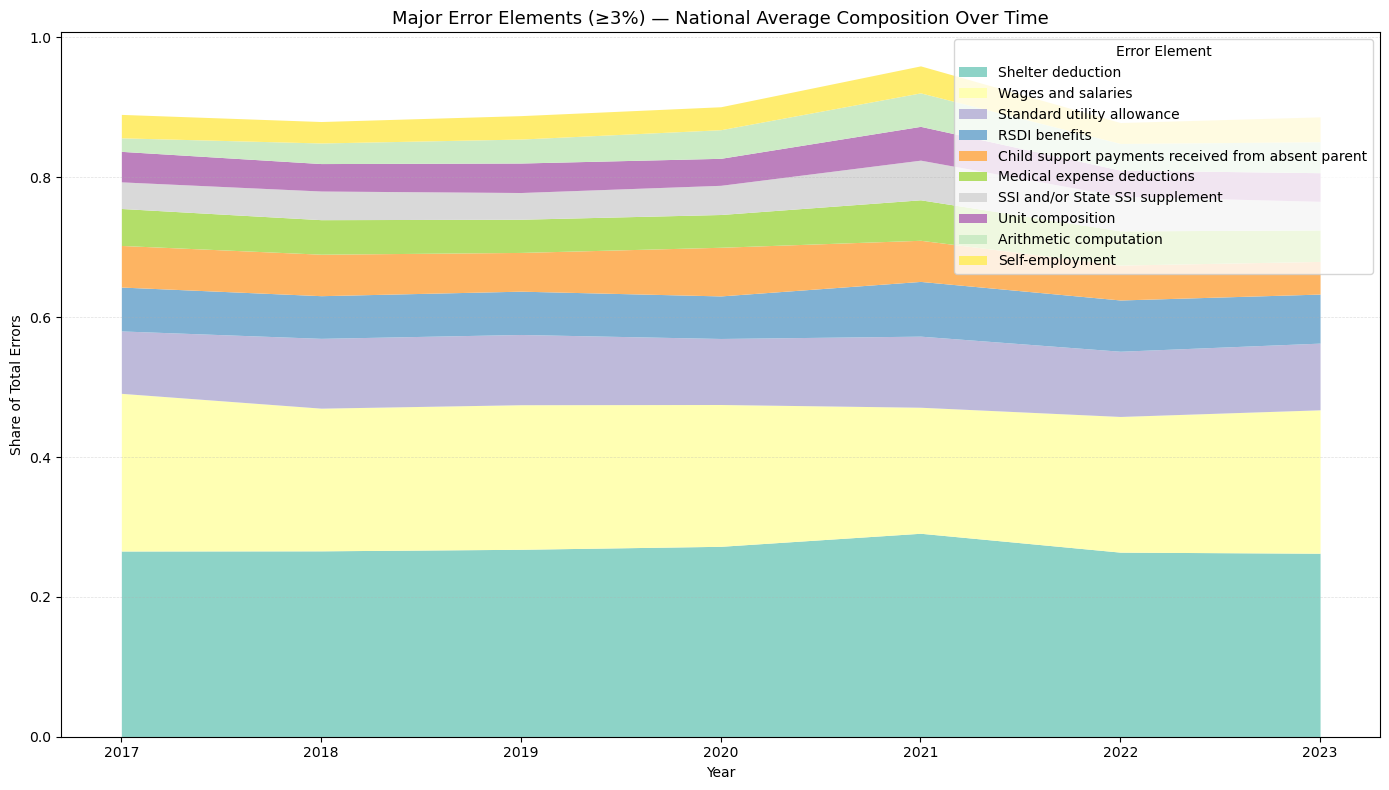

In [52]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# 1️⃣ 过滤主要 error element
filtered = error_dist[error_dist["Error Element"].isin(major_elements)]

# 2️⃣ 计算每个 error element 的平均 share（可改为 sum()）
mean_share = (
    filtered.groupby("Error Element")["Share"]
    .mean()
    .sort_values(ascending=False)
)

# 3️⃣ 按平均 share 排序
pivot = filtered.groupby(["Year", "Error Element"])["Share"].mean().reset_index()
pivot_wide = pivot.pivot(index="Year", columns="Error Element", values="Share")
pivot_wide = pivot_wide[mean_share.index]  # 按从大到小排序列

# 4️⃣ 设置固定颜色（tab20 调色板前 len(mean_share) 个颜色）
colors = cm.get_cmap("Set3", len(mean_share))
color_list = [colors(i) for i in range(len(mean_share))]

# 5️⃣ 绘制面积图
plt.figure(figsize=(14, 8))
pivot_wide.plot.area(
    figsize=(14, 8),
    color=color_list,
    linewidth=0,
    # edgecolor='none'
)
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.4)

# 6️⃣ 设置标题、坐标轴和图例
plt.title("Major Error Elements (≥3%) — National Average Composition Over Time", fontsize=13)
plt.ylabel("Share of Total Errors")
plt.xlabel("Year")

plt.legend(
    title="Error Element",
    # labels=mean_share.index,      # legend 按面积顺序排列
    # bbox_to_anchor=(1.25, 1),
    loc="upper right",
)

# 7️⃣ 优化布局与导出
plt.tight_layout()
plt.savefig("error_element_distribution_sorted_fixedcolor.png", dpi=300, bbox_inches="tight")
plt.show()


C:\Users\27311\AppData\Local\Temp\ipykernel_22952\3010841375.py:18: UserWarning: Glyph 128 (\x80) missing from current font.
  plt.tight_layout()
C:\Users\27311\AppData\Local\Temp\ipykernel_22952\3010841375.py:18: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()
D:\soft\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128 (\x80) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


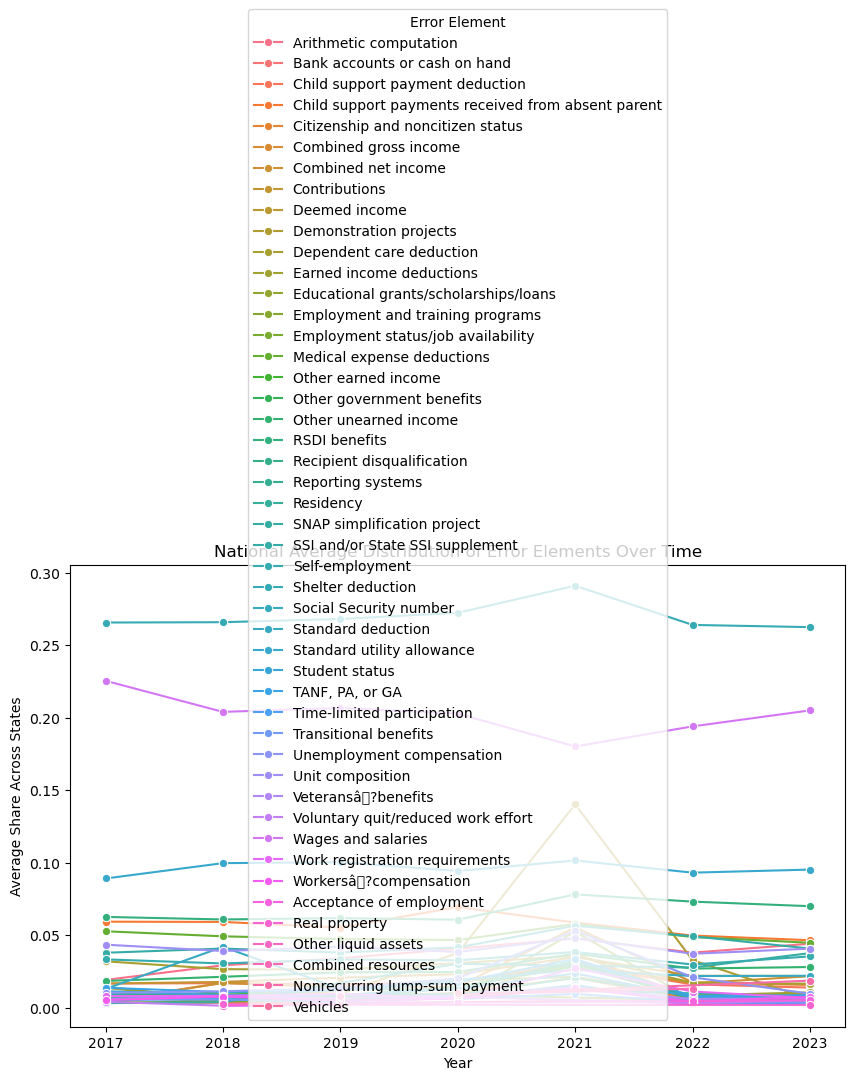

In [30]:
# 各年每种 Error Element 的全国平均占比
trend = (
    error_dist.groupby(["Year", "Error Element"])["Share"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=trend,
    x="Year",
    y="Share",
    hue="Error Element",
    marker="o"
)
plt.title("National Average Distribution of Error Elements Over Time")
plt.ylabel("Average Share Across States")
plt.tight_layout()
plt.show()


In [36]:
# 计算每个 Error Element 在所有年份的平均 share
avg_share = (
    error_dist.groupby("Error Element")["Share"]
    .mean()
    .sort_values(ascending=False)
)

top3_elements = avg_share.head(3).index.tolist()
print("Top 3 Error Elements:", top3_elements)


Top 3 Error Elements: ['Shelter deduction', 'Wages and salaries', 'Standard utility allowance']
